In [1]:
import pandas as pd
import numpy as np
import datetime

#### OPENROUTER API
- provide only 50 req/day

In [2]:
import os
from dotenv import load_dotenv

load_dotenv("secret.env")

api_key = os.getenv("OPENROUTER_AI_API_KEY")

if api_key is None:
    print("Error: OPENROUTER_AI_API_KEY not found in .env file or environment variables.")
else:
    print("OPENROUTER_AI_API_KEY loaded successfully.")

OPENROUTER_AI_API_KEY loaded successfully.


In [3]:
import requests
import json
response = requests.get(
  url="https://openrouter.ai/api/v1/auth/key",
  headers={
    "Authorization": f"Bearer {api_key}"
  }
)
print(json.dumps(response.json(), indent=2))

{
  "data": {
    "label": "sk-or-v1-4eb...7b1",
    "limit": null,
    "usage": 0.12919039,
    "is_provisioning_key": false,
    "limit_remaining": null,
    "is_free_tier": true,
    "rate_limit": {
      "requests": 10,
      "interval": "10s"
    }
  }
}


In [4]:
from openai import OpenAI

client = OpenAI(
  base_url="https://openrouter.ai/api/v1",
  api_key=api_key,
)

In [5]:
prompt = """You are a financial news analyst specializing in stock market impact. Your task is to analyze the provided news article, summarize its core content concisely, determine its sentiment (positive, negative, or neutral), and assess its importance to the specified stock.

Here is the news from stock [STOCK] title and body:
---
[TITLE]
---
[BODY]
---

Please provide your analysis in the following format (Don't forget to make space between the sections as shown):

**Sentiment:**
[Positive / Negative / Neutral]

**Summary:**
[Your concise summary of the article, typically 2-3 sentences.]

**Reasoning for Sentiment:**
[Brief explanation (1-2 sentences) of why you categorized the sentiment as such, referencing key points or tone from the article.]

**Importance to Stock [STOCK]:**
[1-5, where 1 is minimal importance and 5 is very high importance.] (Answer only in number 1-5)

**Reasoning for Importance:**
[Brief explanation (1-2 sentences) of why you assigned this importance score, referencing specific details from the article that would impact the stock.]"""

In [ ]:
df = pd.read_csv("../../DataCollection/Data/Trending/2025-05-27_22-43-20.csv")
display(df.head())

,publish_date,publish_time,title,body_text,url
0,2025-05-27,10:33,US Consumer bounces back sharply in May By Inv...,Investing.com -- Consumer confidence rebounded...,https://www.investing.com/news/economy-news/us...
1,2025-05-27,10:29,Eli Lilly expands pain pipeline with acquisiti...,Investing.com -- Eli Lilly and Company (NYSE: ...,https://www.investing.com/news/stock-market-ne...
2,2025-05-27,09:41,"Lynx: Risk priced in, Nvidia could surprise to...",Investing.com -- Nvidia stock could break out ...,https://www.investing.com/news/stock-market-ne...
3,2025-05-27,09:16,Trump Media & Technology Group Announces $2.5B...,Trump Media and Technology Group Corp. (Nasdaq...,https://www.investing.com/news/cryptocurrency-...
4,2025-05-27,09:15,SoundHound shares jump as Piper Sandler starts...,Investing.com -- Piper Sandler has initiated c...,https://www.investing.com/news/stock-market-ne...


In [7]:
df["title"] = df["title"].astype(str)
df["body_text"] = df["body_text"].astype(str)
df.isnull().sum()

publish_date    0
publish_time    0
title           0
body_text       0
url             0
dtype: int64

In [8]:
from tqdm import tqdm
predicted = []

for index, row in tqdm(df.iterrows(), total=len(df), desc="Prompting"): 
    
    current_stock = row.get("ticker", "news")

    filled_prompt = prompt.replace("[STOCK]", current_stock)
    filled_prompt = filled_prompt.replace("[TITLE]", row["title"])
    filled_prompt = filled_prompt.replace("[BODY]", row["body_text"])
    
    response = client.chat.completions.create(
        extra_body={
            "provider": {
            "sort": "throughput"
            }
        },
        model="deepseek/deepseek-chat-v3-0324:free",
        messages=[
            {"role": "system", "content": "You are a financial news analyst."},
            {"role": "user", "content": filled_prompt}
        ]
    )
    
    predicted.append(response.choices[0].message.content)

Prompting:   0%|          | 0/20 [00:00<?, ?it/s]

Prompting: 100%|██████████| 20/20 [03:11<00:00,  9.57s/it]


In [9]:
predicted = np.array(predicted)
df["predicted"] = predicted

In [10]:
df["sentiment"] = df["predicted"].apply(lambda x: x.split("\n")[1].strip() if len(x.split("\n")) > 1 else None)
df["importance"] = df["predicted"].apply(lambda x: x.split("\n")[10].strip() if len(x.split("\n")) > 10 else None)
df["summary"] = df["predicted"].apply(lambda x: x.split("\n")[4].strip() if len(x.split("\n")) > 4 else None)

In [11]:
df[["title", "sentiment", "importance", "summary"]]

,title,sentiment,importance,summary
0,US Consumer bounces back sharply in May By Inv...,Positive,4,"Consumer confidence rebounded sharply in May, ..."
1,Eli Lilly expands pain pipeline with acquisiti...,Positive,4,Eli Lilly is acquiring SiteOne Therapeutics fo...
2,"Lynx: Risk priced in, Nvidia could surprise to...",Positive,5,Lynx Equity raises Nvidia's price target to $1...
3,Trump Media & Technology Group Announces $2.5B...,Positive,5,Trump Media & Technology Group announced a $2....
4,SoundHound shares jump as Piper Sandler starts...,Positive,4,Piper Sandler initiated coverage on SoundHound...
5,25% tariff not enough to push Apple to reshore...,Negative,3,Morgan Stanley analysts argue that a 25% tarif...
6,"Next 300 points likely up for the S&P 500, say...",Positive,4,JPMorgan analysts predict a 300-point upside f...
7,JPMorgan shifts to bullish stance on crypto am...,Positive,4,JPMorgan has shifted to a bullish stance on di...
8,New surveys show declining interest in EVs and...,Negative,4,Recent surveys indicate declining consumer int...
9,Temu owner PDD Holdings shares fall sharply on...,Negative,5,PDD Holdings (owner of Temu) reported Q1 earni...


In [12]:
df = df[df['sentiment'].isin(['Positive', 'Negative', 'Neutral'])]
df = df[df['importance'].isin(['1', '2', '3', '4', '5'])]

<Axes: title={'center': 'Sentiment Distribution'}, xlabel='sentiment'>

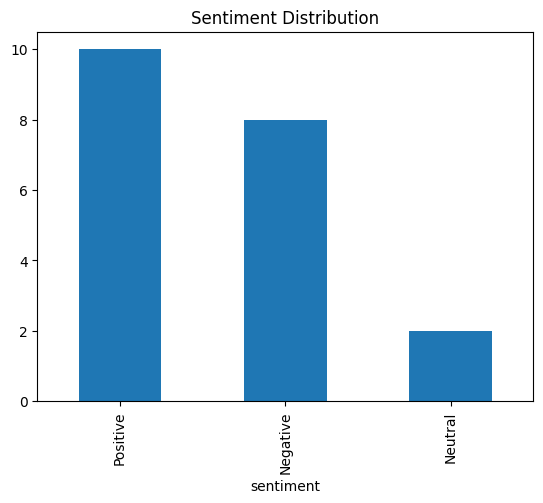

In [13]:
df['sentiment'].value_counts().plot(kind='bar', title='Sentiment Distribution')

<Axes: title={'center': 'Importance Distribution'}, xlabel='importance'>

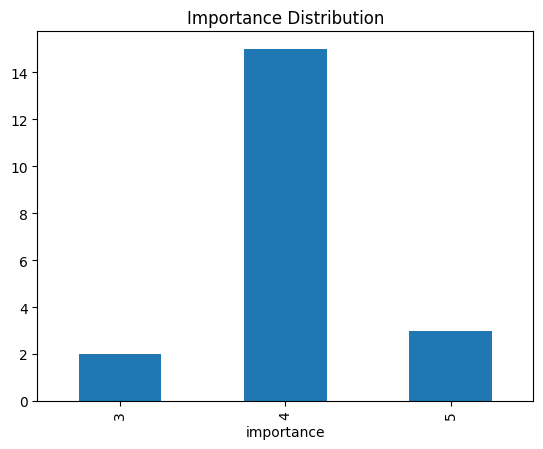

In [14]:
df['importance'].value_counts().sort_index().plot(kind='bar', title='Importance Distribution')

In [15]:
TICKER=current_stock

In [16]:
def calculate_sentiment_score(df):
    sentiment_scores = {
        'Positive': 1,
        'Negative': -1,
        'Neutral': 0
    }
    
    df['sentiment_score'] = df['sentiment'].map(sentiment_scores)
    
    df['weighted_score'] = df['sentiment_score'] * df['importance'].astype(int)
    
    total_importance = df['importance'].astype(int).sum()
    
    if total_importance == 0:
        return 0
    
    sentiment_score = df['weighted_score'].sum() / total_importance
    return sentiment_score

In [17]:
print(f"Sentiment Score for {TICKER}: {calculate_sentiment_score(df).round(2)}")

Sentiment Score for news: 0.14


In [18]:
import datetime

df.drop(columns=['predicted','body_text'],inplace=True)
now = datetime.datetime.now()
date_time = now.strftime("%Y-%m-%d %H-%M-%S").strip().replace(' ', '_')
df.to_csv(f"Output/DeepSeek/DeepSeek_{TICKER}_{date_time}.csv", index=False)